In [2]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from matplotlib.colors import LinearSegmentedColormap
import cv2

from models import CocoVGG
# from datasets import NSDDatasetClassSubset

In [2]:
def getClassImages(dataDir:str, imgDataFolerDir: str, subj: int, className: str):
    pickleFilePath = os.path.join(imgDataFolerDir, f"subj0{subj}ImgData.pkl")
    imgData = pd.read_pickle(pickleFilePath)
    imageIDsInClass = imgData[imgData["classLabel"] == "person"]["nsdId"].values
    trainingImagesPath = os.path.join(dataDir, f"subj0{1}/training_split/training_images/")
    subjImages = os.listdir(trainingImagesPath)
    imagesInClass = []
    trainingIDsInClass = []
    for image in subjImages:
        imageSplits = image.split("-") # ['train', '0004_nsd', '00085.png']
        trainingID = int(imageSplits[1].rstrip("_nsd")) - 1
        nsdID = imageSplits[-1] # removes 'train-0001_nsd-' and keeps '00013.png'
        nsdID = nsdID.rstrip(".png") #removes png file type
        nsdID = int(nsdID)
        if nsdID in imageIDsInClass:
            imagesInClass.append(os.path.join(trainingImagesPath, image))
            trainingIDsInClass.append(trainingID)
    return np.array(imagesInClass), np.array(trainingIDsInClass)

    


def getAvgROI(parentFolderDir: str, subj: int, fmriData, hemi: str = "l"):
    rois = np.array(["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"])
    avgRoiValues = np.zeros((len(fmriData), len(rois)))
    for i in range(len(rois)):
        roi = rois[i]
        if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
            roi_class = 'prf-visualrois'
        elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
            roi_class = 'floc-bodies'
        elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
            roi_class = 'floc-faces'
        elif roi in ["OPA", "PPA", "RSC"]:
            roi_class = 'floc-places'
        elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
            roi_class = 'floc-words'
        elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
            roi_class = 'streams'
        roiMap = np.load(f"{parentFolderDir}/subj0{subj}/roi_masks/mapping_{roi_class}.npy", allow_pickle=True).item()
        challenge_roi_class = np.load(f"{parentFolderDir}/subj0{subj}/roi_masks/{hemi}h.{roi_class}_challenge_space.npy")
        # Select the vertices corresponding to the ROI of interest
        roi_mapping = list(roiMap.keys())[list(roiMap.values()).index(roi)]
        challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
        # print(roi_mapping)       
        vals = fmriData[:,np.where(challenge_roi)[0]].mean(axis = 1)
        avgRoiValues[:, i] = vals
    mask = np.arange(len(avgRoiValues[0]))
    print(mask)
    mask = mask[~np.isnan(avgRoiValues.max(axis=0))]
    print(mask)
    return rois[mask], avgRoiValues[:, mask]


In [3]:
class NSDDatasetClassSubset(Dataset):
    def __init__(self, parentFolderDir: str, imgDataFolderDir: str, subj: int, className: str, idxs: list = None, tsfms = None):
        self.imgPaths, self.trainingIDs = getClassImages(parentFolderDir, imgDataFolderDir, subj, className)
        self.lhFMRI = np.load(os.path.join(parentFolderDir, f"subj0{subj}/training_split/training_fmri/lh_training_fmri.npy"))[self.trainingIDs]
        self.rhFMRI = np.load(os.path.join(parentFolderDir, f"subj0{subj}/training_split/training_fmri/rh_training_fmri.npy"))[self.trainingIDs]
        self.tsfms = tsfms
        self.lhROIs, self.lhAvgROIs = getAvgROI(parentFolderDir, subj, self.lhFMRI)
        self.rhROIs, self.rhAvgROIs = getAvgROI(parentFolderDir, subj, self.rhFMRI, "r")
        if idxs is not None:
            print("not null")
            self.imgPaths = self.imgPaths[idxs]
            self.lhFMRI = self.lhFMRI[idxs]
            self.rhFMRI = self.rhFMRI[idxs]
            self.lhAvgROIs = self.lhAvgROIs[idxs]
            self.rhAvgROIs = self.rhAvgROIs[idxs]
    def __len__(self):
        return len(self.imgPaths)
    def __getitem__(self, idx):
        img = Image.open(self.imgPaths[idx])
        lh = self.lhFMRI[idx]
        rh = self.rhFMRI[idx]
        lhAvg = self.lhAvgROIs[idx]
        rhAvg = self.rhAvgROIs[idx]
        if self.tsfms:
            img = self.tsfms(img)
        return img, self.imgPaths[idx], torch.from_numpy(lh), torch.from_numpy(rh), torch.tensor(lhAvg, dtype = torch.float32), torch.tensor(rhAvg, dtype = torch.float32)


In [17]:
class roiVGG(torch.nn.Module):
    def __init__(self, numClasses: int, cocoVGGWeights, numROIs: int):
        super(roiVGG, self).__init__()
        self.cocoVgg19 = CocoVGG(numClasses)
        self.cocoVgg19.load_state_dict(torch.load(cocoVGGWeights, map_location="cpu"))

        self.convFeatures = self.cocoVgg19.features[:36]
        self.maxPool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False)
        self.adaptiveAvgPool = torch.nn.AdaptiveAvgPool2d(output_size = (7, 7))

        self.cocoClassifier = self.cocoVgg19.classifier
        self.roiClassifier = torch.nn.Sequential(
            torch.nn.Linear(in_features = 25088, out_features = 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features = 4096, out_features = 1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features = 1024, out_features = numROIs)
        )

        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, img):
        extractedFeatures = self.convFeatures(img)
        hook = extractedFeatures.register_hook(self.activations_hook)
        intermediateOutput = self.maxPool(extractedFeatures)
        intermediateOutput = self.adaptiveAvgPool(intermediateOutput)
        intermediateOutput = torch.flatten(intermediateOutput, 1)
        return self.cocoClassifier(intermediateOutput), self.roiClassifier(intermediateOutput)

    def get_activation_gradient(self):
        return self.gradients

    def get_activations(self, img):
        return self.convFeatures(img)


In [18]:
model = roiVGG(79, "./cocoVGGModel.pth", 32)

In [4]:
device = "cpu"
subj = 1
parentDir = "C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/"
metaDataDir = "C:/Users/josem/Documents/schoolWork/MQP/Git/MQPCode/test/subjCocoImgData/"

tsfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# len(getClassImages(parentDir, metaDataDir, subj, "person")[0])

1837

In [8]:

# getClassImages(parentDir, metaDataDir, subj, "person")
numImages = len(getClassImages(parentDir, metaDataDir, subj, "person")[0])
trainIdxs, validIdxs = train_test_split(range(numImages), train_size=0.9)

trainingDataset = NSDDatasetClassSubset(parentDir, metaDataDir, subj, "person", idxs=trainIdxs, tsfms = tsfms)
trainDataLoader = DataLoader(trainingDataset, batch_size = 64, shuffle = True)

validDataset = NSDDatasetClassSubset(parentDir, metaDataDir, subj, "person", idxs = validIdxs, tsfms = tsfms)
validDataLoader = DataLoader(validDataset, batch_size = 64, shuffle = True)

C:\Users\josem\AppData\Local\Temp\ipykernel_17788\2524252945.py:54: RuntimeWarning: Mean of empty slice.
  vals = fmriData[:,np.where(challenge_roi)[0]].mean(axis = 1)
c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8 11 12 16 17 18 19 20 21 22 24 25 26 27 28 29
 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 16 17 18 19 20 21 24 25 26 27 28
 29 30]


C:\Users\josem\AppData\Local\Temp\ipykernel_17788\2524252945.py:54: RuntimeWarning: Mean of empty slice.
  vals = fmriData[:,np.where(challenge_roi)[0]].mean(axis = 1)
c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8 11 12 16 17 18 19 20 21 22 24 25 26 27 28 29
 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 16 17 18 19 20 21 24 25 26 27 28
 29 30]


In [9]:
trainingDataset.trainingIDs

array([   3,   10,   16, ..., 9830, 9835, 9836])

In [5]:
img, imgPath, _, _, _, _ = trainDataset.__getitem__(0)

In [10]:
img = img[None, :, :, :]

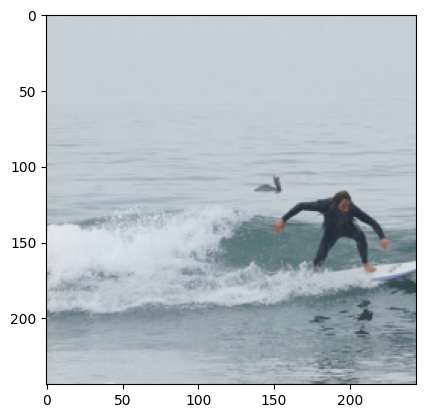

In [11]:
plt.imshow(img[0].permute(1,2,0))

In [31]:
pred = model(img)


In [30]:
pred[1]

tensor([[ 0.0090, -0.0200, -0.0095, -0.0425,  0.0254,  0.0075,  0.0066, -0.0054,
         -0.0240, -0.0020, -0.0282,  0.0026,  0.0011, -0.0019,  0.0491, -0.0070,
          0.0216, -0.0449, -0.0241,  0.0071, -0.0092, -0.0107, -0.0261,  0.0130,
          0.0305,  0.0246,  0.0175, -0.0453, -0.0133,  0.0006,  0.0169, -0.0345]],
       grad_fn=<AddmmBackward0>)

In [32]:
torch.argmax(pred[1])

tensor(14)

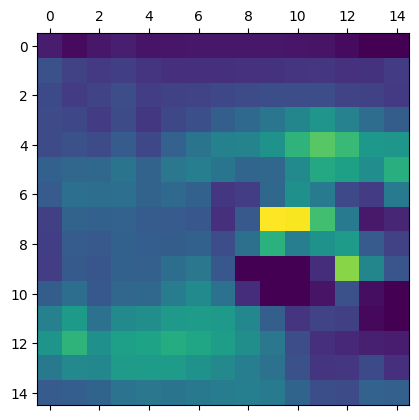

In [33]:
pred[1][:, 14].backward()
gradients = model.get_activation_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

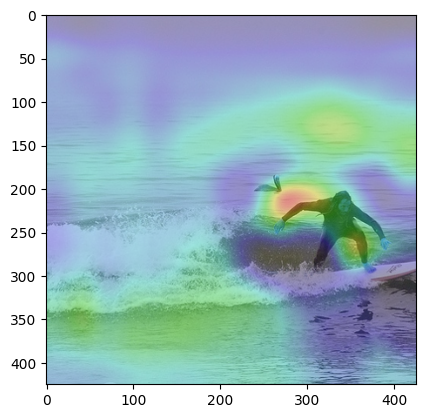

In [38]:
img = cv2.imread(imgPath)
actual = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

cmap = LinearSegmentedColormap.from_list("Jet", [(0,0,0), (0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)])

normalized_data = (actual - actual.min()) / (actual.max() - actual.min())

# Apply colormap and convert to integer array
heatmapNew = (cmap(normalized_data) * 255).astype(np.uint8)

# Apply the heatmap to the original image
superimposed_img = cv2.addWeighted(img, 0.7, heatmapNew[:,:,:3], 0.3, 0)
plt.imshow(superimposed_img)